In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb

In [31]:
print('Loading data...')
#Loading data
train = pd.read_csv( 'E:\\6010S\\project\\train.csv', dtype={'msno' : 'category',
                                                'source_system_tab' : 'category',
                                                  'source_screen_name' : 'category',
                                                  'source_type' : 'category',
                                                  'target' : np.uint8,
                                                  'song_id' : 'category'})
test = pd.read_csv('E:\\6010S\\project\\test.csv', dtype={'msno' : 'category',
                                                'source_system_tab' : 'category',
                                                'source_screen_name' : 'category',
                                                'source_type' : 'category',
                                                'song_id' : 'category'})
songs = pd.read_csv('E:\\6010S\\project\\songs.csv',dtype={'genre_ids': 'category',
                                                  'language' : 'category',
                                                  'artist_name' : 'category',
                                                  'composer' : 'category',
                                                  'lyricist' : 'category',
                                                  'song_id' : 'category'})
members = pd.read_csv( 'E:\\6010S\\project\\members.csv',dtype={'city' : 'category',
                                                      'bd' : np.uint8,
                                                      'gender' : 'category',
                                                      'registered_via' : 'category'})
songs_extra = pd.read_csv('E:\\6010S\\project\\song_extra_info.csv')

Loading data...


In [37]:
train.head(6)

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1
5,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3Hg5kugV1S0wzEVLAEfqjIV5UHzb7bCrdBRQlGygLvU=,explore,Explore,online-playlist,1


In [39]:
members.head(6)

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613
5,zgPOEyUn5a/Fvuzb3m69ajzxjkbblVtObglW89FzLdo=,13,43,female,9,20120703,20171006


In [38]:
songs.head(6)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0
5,kKJ2JNU5h8rphyW21ovC+RZU+yEHPM+3w85J37p7vEQ=,235520,864|857|850|843,貴族精選,Joe Hisaishi,Hayao Miyazaki,17.0


In [4]:
print('Data preprocessing...')
#Do a left join with the training and test data
song_columns = ['song_id', 'artist_name', 'genre_ids', 'song_length', 'language']
train = train.merge(songs[song_columns], on='song_id', how='left')
test = test.merge(songs[song_columns], on='song_id', how='left')

Data preprocessing...


In [5]:
#split time into three fields: year, month and date
members['registration_year'] = members['registration_init_time'].apply(lambda x: int(str(x)[0:4]))
members['registration_month'] = members['registration_init_time'].apply(lambda x: int(str(x)[4:6]))
members['registration_date'] = members['registration_init_time'].apply(lambda x: int(str(x)[6:8]))

members['expiration_year'] = members['expiration_date'].apply(lambda x: int(str(x)[0:4]))
members['expiration_month'] = members['expiration_date'].apply(lambda x: int(str(x)[4:6]))
members['expiration_date'] = members['expiration_date'].apply(lambda x: int(str(x)[6:8]))
members = members.drop(['registration_init_time'], axis=1)

In [6]:
#Get counrty from isrc
#https://isrc.ifpi.org/en/isrc-standard/structure
def get_country_by_isrc(isrc):
    return str(isrc)[:2]
songs_extra["song_country"] = songs_extra.isrc.dropna().apply(get_country_by_isrc)

In [7]:
#get song regist year from isrc
def get_year_by_isrc(isrc):
    yy = int(str(isrc)[5:7])
    if yy > 17 and yy <= 39: 
        return np.nan
    elif yy > 39:
        return 1900 + yy
    else:
        return 2000 + yy
songs_extra["song_year"] = songs_extra.isrc.dropna().apply(get_year_by_isrc)
songs_extra.drop(["isrc","name"], axis=1, inplace=True)

In [8]:
songs_extra

,song_id,song_country,song_year
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,TW,2012.0
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,QM,2016.0
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,TW,2008.0
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,US,2013.0
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,TW,2013.0
5,QU8f6JR0/cwLGSqJX2XDVzFK0DxMaIUY15ALJXK7ziw=,GB,2014.0
6,O1Oj4CmnZhbHl7oyBaHSpGeu5gvcSmUydY3Awmv3uxk=,HK,2007.0
7,Tr5R61AuEkN8UelOCzu09ZwQi7/HmP9sQmxf9rFngIg=,US,2004.0
8,ie9l12ZYXEaP4evrBBUvnNnZGdupHSX5NU+tEqB1SDg=,HK,2002.0
9,6mICNlckUVGuoK/XGC7bnxXf5s2ZnkpFHShaGL/zM2Y=,TW,2010.0


In [9]:
#eliminate unrealistic age
members.loc[(members.bd <= 0) | (members.bd > 80), "bd"] = np.nan

In [10]:
#count the popularity of songs
song_count = train.song_id.value_counts().add(test.song_id.value_counts(), fill_value=0)
train['song_count'] = pd.merge(pd.DataFrame(train.song_id), pd.DataFrame(song_count), 
                                     how='left', left_on='song_id', right_index=True, suffixes=('', '_count'))['song_id_count']
test['song_count'] = pd.merge(pd.DataFrame(test.song_id), pd.DataFrame(song_count), 
                                    how='left', left_on='song_id', right_index=True, suffixes=('', '_count'))['song_id_count']
train['song_count'] = train['song_count'].astype(np.float64)
test['song_count'] = test['song_count'].astype(np.float64)

In [11]:
#count the popularity of artists
#artist_count = train.artist_name.value_counts().add(test.artist_name.value_counts(), fill_value=0)
#train['artist_count'] = pd.merge(pd.DataFrame(train.artist_name), pd.DataFrame(artist_count), how='left', 
#                                       left_on='artist_name', right_index=True, suffixes=('', '_count'))['artist_name_count']
#test['artist_count'] = pd.merge(pd.DataFrame(test.artist_name), pd.DataFrame(artist_count), how='left', 
#                                      left_on='artist_name', right_index=True, suffixes=('', '_count'))['artist_name_count']
#train['artist_count'] = train['artist_count'].astype(np.float64)
#test['artist_count'] = test['artist_count'].astype(np.float64)

In [12]:
#merge all the data into train and test datasets
train = train.merge(members, on='msno', how='left')
test = test.merge(members, on='msno', how='left')

train = train.merge(songs_extra, on = 'song_id', how = 'left')
test = test.merge(songs_extra, on = 'song_id', how = 'left')


In [13]:
#eliminate the garbage data
import gc
del members, songs; gc.collect();

for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype('category')
        test[col] = test[col].astype('category')

X = train.drop(['target'], axis=1)
y = train['target'].values

X_test = test.drop(['id'], axis=1)
ids = test['id'].values

del train, test; gc.collect();

d_train = lgb.Dataset(X, y)
watchlist = [d_train]

In [14]:
#training LGBM model
params = {}
params['learning_rate'] = 0.2
params['application'] = 'binary'
params['max_depth'] = 16
params['num_leaves'] = 2**8
params['verbosity'] = 0
params['metric'] = 'auc'
model = lgb.train(params, train_set=d_train, num_boost_round=200, valid_sets=watchlist, verbose_eval=5)
print('Making predictions and saving them...')
p_test = model.predict(X_test)
subm = pd.DataFrame()
subm['id'] = ids
subm['target'] = p_test
subm.to_csv('E:\\6010S\\project\\submission.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')


[5]	training's auc: 0.750306
[10]	training's auc: 0.763976
[15]	training's auc: 0.771561
[20]	training's auc: 0.776678
[25]	training's auc: 0.780245
[30]	training's auc: 0.783143
[35]	training's auc: 0.785587
[40]	training's auc: 0.788233
[45]	training's auc: 0.790117
[50]	training's auc: 0.791915
[55]	training's auc: 0.794179
[60]	training's auc: 0.796537
[65]	training's auc: 0.798815
[70]	training's auc: 0.80043
[75]	training's auc: 0.802318
[80]	training's auc: 0.804002
[85]	training's auc: 0.805293
[90]	training's auc: 0.80649
[95]	training's auc: 0.807859
[100]	training's auc: 0.809684
[105]	training's auc: 0.811081
[110]	training's auc: 0.812528
[115]	training's auc: 0.813786
[120]	training's auc: 0.814823
[125]	training's auc: 0.816284
[130]	training's auc: 0.817413
[135]	training's auc: 0.81846
[140]	training's auc: 0.819467
[145]	training's auc: 0.820327
[150]	training's auc: 0.821805
[155]	training's auc: 0.822775
[160]	training's auc: 0.823729
[165]	training's auc: 0.824403


In [15]:
#get model importance
import matplotlib.pyplot as plt

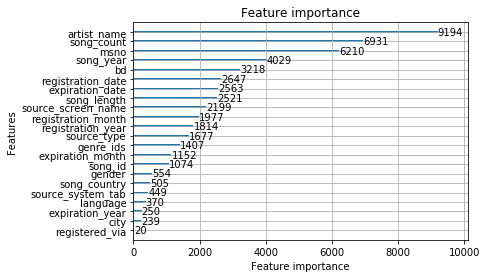

In [16]:
lgb.plot_importance(model)